라이브러리 임포트

In [1]:
## library import - data preprocessing
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder

In [2]:
## BERT embedding 
from transformers import BertTokenizer, BertModel
import torch 

In [3]:
## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import randint, uniform

In [5]:
## 평가 지표 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr

In [6]:
## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [7]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [8]:
# tqdm 
from tqdm import tqdm 

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
# kaggle hub
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [11]:
# load new game Dataset
file_path = r"C:\KHU\KHU_2025\머신러닝기초및응용_김민경교수님\Youtube_music_11000.csv"

# 데이터 로드
df = pd.read_csv(file_path)

In [12]:
df.head()

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,thumbnail_link,date,keyword
0,uelHwf8o7_U,Eminem - Love The Way You Lie ft. Rihanna,EminemVEVO,10,Love The Way You Lie|Eminem|Rihanna|Recovery|M...,2987149992,14605627,0,635964,https://i.ytimg.com/vi/uelHwf8o7_U/default.jpg,5.08,hip hop
1,5qm8PH4xAss,50 Cent - In Da Club (Official Music Video),50CentVEVO,10,50 CENT|50 CENT IN DA CLUB|IN DA CLUB|IN DA CL...,2390681337,13992025,0,375904,https://i.ytimg.com/vi/5qm8PH4xAss/default.jpg,16.06,hip hop
2,8WYHDfJDPDc,Nelly - Dilemma (Official Music Video) ft. Kel...,NellyVEVO,10,NELLY DILEMMA|DILEMMA|DILEMMA NELLY|DILEMMA of...,1724349309,8857593,0,203244,https://i.ytimg.com/vi/8WYHDfJDPDc/default.jpg,5.10,hip hop
3,6EEW-9NDM5k,Akon - Lonely (Official Music Video),AkonVEVO,10,AKON|AKON LONELY|LONELY|LONELY AKON|LONELY off...,1228098563,10929063,0,322468,https://i.ytimg.com/vi/6EEW-9NDM5k/default.jpg,17.06,hip hop
4,oKOtzIo-uYw,Fugees - Killing Me Softly With His Song (Offi...,TheFugeesVEVO,10,killing me softly|fugees|fugees killing me sof...,688270605,4019948,0,63910,https://i.ytimg.com/vi/oKOtzIo-uYw/default.jpg,27.03,hip hop


In [13]:
# 데이터 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        10950 non-null  object 
 1   title           10950 non-null  object 
 2   channel_title   10950 non-null  object 
 3   category_id     10950 non-null  int64  
 4   tags            10950 non-null  object 
 5   views           10950 non-null  int64  
 6   likes           10950 non-null  int64  
 7   dislikes        10950 non-null  int64  
 8   comment_count   10950 non-null  int64  
 9   thumbnail_link  10950 non-null  object 
 10  date            10950 non-null  float64
 11  keyword         10950 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [14]:
# 필요한 칼럼만 추출
df = df[['title', 'views']].copy()

Text(0, 0.5, 'Frequency')

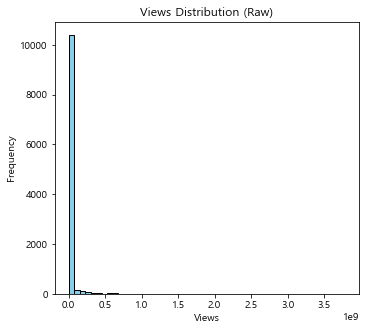

In [15]:
# 원본 분포
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['views'], bins=50, color='skyblue', edgecolor='black')
plt.title('Views Distribution (Raw)')
plt.xlabel('Views')
plt.ylabel('Frequency')

In [16]:
# target scaling
df['log_views'] = np.log1p(df['views'])

# scaler = StandardScaler()
# df['scaled_views'] = scaler.fit_transform(df[['log_views']])

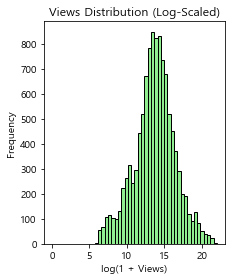

In [17]:
# 로그 변환 분포
plt.subplot(1, 2, 2)
plt.hist(df['log_views'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Views Distribution (Log-Scaled)')
plt.xlabel('log(1 + Views)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
# BERT load 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
# BERT embedding extract 
## CLS 벡터 추출 함수 정의 
def extract_cls_embedding(text):
    encoding = tokenizer(text,
                         max_length=32,
                         truncation=True,
                         padding='max_length',
                         return_tensors='pt')
    input_ids_tensor = encoding['input_ids'].to(device)
    attention_mask_tensor = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

In [20]:
## 제목을 cls로 추출 
embeddings = np.array([
    extract_cls_embedding(title) for title in tqdm(df['title'])
])

100%|████████████████████████████████████████████████████████████████████████████| 10950/10950 [15:53<00:00, 11.48it/s]


In [21]:
X = embeddings
y = df['log_views']

# test, train dataset 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [22]:
# Model 성능 평가 함수 
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Spearman: {spearman_corr:.4f}")
    
    return model, rmse, r2, spearman_corr

Lasso(random search)

In [23]:
#모델 정의
lasso = Lasso(random_state=42, max_iter=10000)

#탐색할 하이퍼파라미터 범위 정의
param_dist = {'alpha': loguniform(1e-5, 10)} #로그스케일로 탐색

# RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    lasso,
    param_distributions=param_dist,
    n_iter=1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#학습
random_search_lasso.fit(X_train, y_train)

#예측 및 평가
y_pred = random_search_lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

#결과 출력
print("Model: Lasso (RandomizedSearch)")
print("Best alpha:", random_search_lasso.best_params_['alpha'])
print("RMSE:", round(rmse, 4), "R²:", round(r2, 4), "Spearman:", round(spearman_corr, 4))

# 7. 결과 저장
lasso_random_df = pd.DataFrame([{
    "Model": "Lasso (RandomizedSearch)",
    "Alpha": random_search_lasso.best_params_['alpha'],
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
lasso_random_df.to_csv("lasso_random_result(music_randomsearch).csv", index=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: Lasso (RandomizedSearch)
Best alpha: 0.0017670169402947947
RMSE: 1.9882 R²: 0.5011 Spearman: 0.6504


Linear Regression

In [24]:
# LinearRegression 모델 정의 및 학습
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 출력
print("Model: LinearRegression")
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
linear_results_df = pd.DataFrame([{
    "Model": "LinearRegression",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
linear_results_df.to_csv("linear_regression_result.csv", index=False)

Model: LinearRegression
RMSE: 1.9838
R²: 0.5033
Spearman: 0.6572


Ridge(random search)

In [25]:
#모델 정의
ridge = Ridge()

#탐색할 하이퍼파라미터 범위 정의
param_dist = {'alpha': loguniform(1e-5, 10)} #로그스케일 탐색

#RandomizedSearchCV
random_search_ridge = RandomizedSearchCV(
    ridge,
    param_distributions=param_dist,
    n_iter=1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#학습
random_search_ridge.fit(X_train, y_train)

#예측 및 평가
y_pred = random_search_ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

#결과 출력
print("Model: Ridge (RandomizedSearch)")
print("Best alpha:", random_search_ridge.best_params_['alpha'])
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

#결과 저장
ridge_random_df = pd.DataFrame([{
    "Model": "Ridge (RandomizedSearch)",
    "Alpha": random_search_ridge.best_params_['alpha'],
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
ridge_random_df.to_csv("ridge_random_result(music_randomsearch).csv", index=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: Ridge (RandomizedSearch)
Best alpha: 0.0017670169402947947
RMSE: 1.9838
R²: 0.5033
Spearman: 0.6572


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.58457e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


RF(random search)

In [26]:
#하이퍼파라미터 탐색 공간 정의
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

#모델 및 랜덤 서치 정의
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#학습
random_search_rf.fit(X_train, y_train)

#예측 및 평가
y_pred = random_search_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

#출력
print("Model: RandomForest (RandomizedSearch)")
print("Best params:", random_search_rf.best_params_)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

#결과 저장
rf_random_df = pd.DataFrame([{
    "Model": "RandomForest (RandomizedSearch)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
rf_random_df.to_csv("rf_random_result(music_randomsearch).csv", index=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: RandomForest (RandomizedSearch)
Best params: {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 206}
RMSE: 1.7616
R²: 0.6083
Spearman: 0.7942


Gradient(random search)

In [29]:
#하이퍼파라미터 분포 정의
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'subsample': uniform(0.6, 0.4)
}

#모델과 랜덤 서치 설정
gbr = GradientBoostingRegressor(random_state=42)
random_search_gbr = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=1,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

#모델 학습
random_search_gbr.fit(X_train, y_train)

#예측 및 평가
y_pred = random_search_gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

#결과 출력
print("Model: GradientBoosting (RandomizedSearch)")
print("Best params:", random_search_gbr.best_params_)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

#결과 저장
gbr_random_df = pd.DataFrame([{
    "Model": "RandomForest (RandomizedSearch)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])

#결과 csv로 저장
gbr_random_df.to_csv("gbr_random_result(music_randomsearch).csv", index=False)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: GradientBoosting (RandomizedSearch)
Best params: {'learning_rate': 0.12236203565420874, 'max_depth': 7, 'min_samples_split': 8, 'n_estimators': 206, 'subsample': 0.9118764001091078}
RMSE: 1.2543
R²: 0.8014
Spearman: 0.8628


In [30]:
# 모델별 결과 DataFrame 합치기
all_results = pd.concat([
    lasso_random_df,
    linear_results_df,
    ridge_random_df,
    rf_random_df,
    gbr_random_df
], ignore_index=True)

#결과 csv로 저장
all_results.to_csv("music_all_results(randomsearch).csv", index=False)

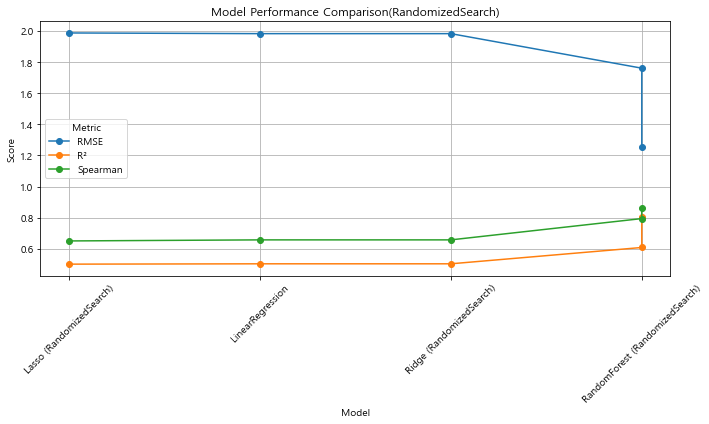

In [31]:
#시각화를 위한 변환 (wide → long)
results_long = all_results.melt(
    id_vars="Model", 
    value_vars=["RMSE", "R²", "Spearman"],
    var_name="Metric", 
    value_name="Score"
)

# 선 그래프(line chart)로 시각화
plt.figure(figsize=(10, 6))
for metric in results_long["Metric"].unique():
    subset = results_long[results_long["Metric"] == metric]
    plt.plot(subset["Model"], subset["Score"], marker='o', label=metric)

plt.title("Model Performance Comparison(RandomizedSearch)")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
music_all_results_randomsearch_saved_df = pd.read_csv("music_all_results(randomsearch).csv")

In [33]:
music_all_results_randomsearch_saved_df

,Model,Alpha,RMSE,R²,Spearman
0,Lasso (RandomizedSearch),0.001767,1.988167,0.501090,0.650395
1,LinearRegression,NaN,1.983782,0.503288,0.657220
2,Ridge (RandomizedSearch),0.001767,1.983773,0.503292,0.657214
3,RandomForest (RandomizedSearch),NaN,1.761627,0.608308,0.794162
4,RandomForest (RandomizedSearch),NaN,1.254296,0.801428,0.862810
